Output has been removed for cells showing data for individual instances due to the sensitive nature of the data.

In [125]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

#sqluser = 'mimicuser'
#dbname = 'mimic'

# Password keyword only necessary if user-specified password required to connect to database
con = psycopg2.connect(dbname=dbname, user=sqluser, password='postgre')
cur = con.cursor()

query = "SELECT" \
        " a.subject_id, a.hadm_id, a.ethnicity, a.insurance, p.gender, cast(a.admittime as date), cast(a.dischtime as date)" \
        ", ROUND( (cast(a.admittime as date) - cast(p.dob as date)) / 365.242)" \
        " AS age_on_admiss" \
        ", cast(a.dischtime as date) - cast(a.admittime as date)" \
        " AS length_of_stay" \
        " FROM admissions a" \
        " INNER JOIN patients p" \
        " ON p.subject_id = a.subject_id" \
        " GROUP BY" \
        " a.subject_id, a.hadm_id, a.ethnicity, a.insurance, p.gender, a.admittime, p.dob, a.dischtime" \
        " ORDER BY a.subject_id;"

cur.execute('SET search_path to ' + schema_name)
df = pd.read_sql_query(query, con)

df.dtypes

subject_id          int64
hadm_id             int64
ethnicity          object
insurance          object
gender             object
admittime          object
dischtime          object
age_on_admiss     float64
length_of_stay      int64
dtype: object

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 9 columns):
subject_id        58976 non-null int64
hadm_id           58976 non-null int64
ethnicity         58976 non-null object
insurance         58976 non-null object
gender            58976 non-null object
admittime         58976 non-null object
dischtime         58976 non-null object
age_on_admiss     58976 non-null float64
length_of_stay    58976 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 4.0+ MB


How many rows correspond to neonates?

In [126]:
len(df[df['age_on_admiss'] < 1])

8110

How many categories of ethnicity are there?

In [127]:
df['ethnicity'].unique()

array(['ASIAN', 'WHITE', 'UNKNOWN/NOT SPECIFIED',
       'BLACK/AFRICAN AMERICAN', 'PATIENT DECLINED TO ANSWER', 'OTHER',
       'HISPANIC OR LATINO', 'HISPANIC/LATINO - GUATEMALAN',
       'ASIAN - CHINESE', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE',
       'MULTI RACE ETHNICITY', 'HISPANIC/LATINO - DOMINICAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'BLACK/AFRICAN', 'HISPANIC/LATINO - SALVADORAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'ASIAN - CAMBODIAN',
       'SOUTH AMERICAN', 'WHITE - EASTERN EUROPEAN', 'ASIAN - FILIPINO',
       'CARIBBEAN ISLAND', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'WHITE - BRAZILIAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'ASIAN - JAPANESE',
       'ASIAN - THAI', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - CUBAN', 'MID

How many categories of gender are there?

In [128]:
df['gender'].unique()

array(['M', 'F'], dtype=object)

How many types of insurance are represented?

In [129]:
df['insurance'].unique()

array(['Private', 'Medicare', 'Medicaid', 'Government', 'Self Pay'],
      dtype=object)

## Readmissions Query and filtering data frame for adult patients

In [ ]:
query_rm = """WITH readmits AS
(
            SELECT subject_id, hadm_id, admittime, dischtime, diagnosis, insurance, admission_type,
            cast(admittime as date) - lag(cast(dischtime as date))
                                            OVER (PARTITION BY subject_id ORDER BY admittime)
                                            AS readmit_time
            FROM admissions
)
SELECT subject_id, hadm_id, readmit_time
FROM readmits
WHERE readmit_time <= 30
ORDER BY subject_id, admittime;"""
#cur.execute('SET search_path to ' + schema_name)
df_rm = pd.read_sql_query(query_rm, con)
df_rm.dtypes

In [ ]:
df2 = df.merge(df_rm, on = ["subject_id","hadm_id"], how = "outer")
df2['is_readmit'] = np.where(df2.readmit_time.isnull(), False, True)
df2['readmit_time'] = np.where(df2.readmit_time.isnull(), 0, df2.readmit_time)

In [ ]:
# Replacing age of >89 y.o. patients with 90
df2['age_on_admiss'] = np.where(df2['age_on_admiss']>100, 90, df2['age_on_admiss'])

# Only keeping rows corresponding to "adults" (non-neonates)
df2 = df2[df2['age_on_admiss'] > 0].copy().reset_index(drop=True)

In [ ]:
df2.head()

In [130]:
len(df2)

50866

## Creating readmission vs. nonreadmission classes

In [ ]:
# Grouping admissions by patient and sorting by admission time within each patient

df2_grouped = df2.groupby('subject_id').apply(pd.DataFrame.sort_values, 'admittime')

In [ ]:
df2_grouped.head()

In [ ]:
# Checking grouping using a patient with known readmission

df2_grouped.loc[99982]

In [ ]:
# Creating a new column indicating whether each stay was followed by an early readmission

# Filling in placeholder "False" values
df2_follow = df2_grouped.copy()
df2_follow['followed_by_readmit'] = False

# Replacing values with True/False based on previous row's "is_readmit" value (only if the rows have same subject_id)
# df2_follow.index[0][1] -> 0
for i in range(len(df2_follow)-1):
    if df2_follow.index[i][0] == df2_follow.index[i+1][0]:
        df2_follow.iloc[i, df2_follow.columns.get_loc('followed_by_readmit')] = df2_follow.iloc[i+1, df2_follow.columns.get_loc('is_readmit')]

In [ ]:
# Checking assignment using same patient with known readmission

df2_follow.loc[99982]

In [ ]:
# Re-setting index

df2_follow.index = df2_follow.index.droplevel(0)
df2_follow.head()

## Pulling in CHARTEVENTS and LABEVENTS data

### Vital signs data

In [ ]:
%%time
# Pulling in vital signs data
# Code adapted from https://github.com/MIT-LCP/mimic-code/blob/master/concepts/pivot/pivoted-vital.sql

query_vitals = """ with ce as
(
  select ce.hadm_id
    , ce.charttime
    , (case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HeartRate
    , (case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP
    , (case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate
    , (case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8 -- converted to degC in valuenum call
               when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then valuenum else null end) as TempC
    , (case when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then valuenum else null end) as SpO2
  from chartevents ce
  -- exclude rows marked as error
  where ce.error IS DISTINCT FROM 1
  and ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,


  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
)
select
    ce.hadm_id
  , ce.charttime
  , avg(HeartRate) as HeartRate
  , avg(SysBP) as SysBP
  , avg(RespRate) as RespRate
  , avg(TempC) as TempC
  , avg(SpO2) as SpO2
from ce
group by ce.hadm_id, ce.charttime
order by ce.hadm_id, ce.charttime;"""

df_vitals = pd.read_sql_query(query_vitals, con)

print(df_vitals.head(5))

In [ ]:
# All-null rows
df_vitals[df_vitals[['heartrate', 'sysbp', 'resprate', 'tempc', 'spo2']].isnull().all(axis=1)].head()

In [131]:
df_vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627341 entries, 0 to 8627340
Data columns (total 7 columns):
hadm_id      int64
charttime    datetime64[ns]
heartrate    float64
sysbp        float64
resprate     float64
tempc        float64
spo2         float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 460.7 MB


### Calculating min., median, and max. of all vital signs for each hospital stay

In [132]:
pd.isnull(df_vitals).any()

hadm_id      False
charttime    False
heartrate     True
sysbp         True
resprate      True
tempc         True
spo2          True
dtype: bool

No rows where hadm_id is null, so no need to drop rows at this point.

In [ ]:
# Aggregating and calculating statistics for each hospital stay

vitals_stats = df_vitals.groupby('hadm_id')['heartrate', 'sysbp', 'resprate', 'tempc', 'spo2'].agg(['min', 'median', 'max'])
vitals_stats.head()

In [ ]:
# Resetting index to make hadm_id a column again for merging consistency

vitals_statsdf = vitals_stats.reset_index()
vitals_statsdf.head()

In [ ]:
# Flattening columns to single layer

vitals_statsdf.columns = ['_'.join(col).rstrip('_') for col in vitals_statsdf.columns.values]

In [ ]:
vitals_statsdf.head()

### Lab data

In [ ]:
%%time
# Pulling in lab data
# Code adapted from https://github.com/MIT-LCP/mimic-code/blob/master/concepts/pivot/pivoted-lab.sql, added RDW values

query_lab = """
SELECT
    pvt.hadm_id, pvt.charttime
  , avg(CASE WHEN label = 'BILIRUBIN' THEN valuenum ELSE null END) as BILIRUBIN
  , avg(CASE WHEN label = 'CREATININE' THEN valuenum ELSE null END) as CREATININE
  , avg(CASE WHEN label = 'HEMATOCRIT' THEN valuenum ELSE null END) as HEMATOCRIT
  , avg(CASE WHEN label = 'HEMOGLOBIN' THEN valuenum ELSE null END) as HEMOGLOBIN
  , avg(CASE WHEN label = 'LACTATE' THEN valuenum ELSE null END) as LACTATE
  , avg(CASE WHEN label = 'PLATELET' THEN valuenum ELSE null END) as PLATELET
  , avg(CASE WHEN label = 'PTT' THEN valuenum ELSE null END) as PTT
  , avg(CASE WHEN label = 'INR' THEN valuenum ELSE null END) as INR
  , avg(CASE WHEN label = 'WBC' THEN valuenum ELSE null end) as WBC
  , avg(CASE WHEN label = 'RDW' THEN valuenum ELSE null end) as RDW
FROM
( -- begin query that extracts the data
  SELECT le.hadm_id, le.charttime
  -- here we assign labels to ITEMIDs
  -- this also fuses together multiple ITEMIDs containing the same data
  , CASE
        WHEN itemid = 50885 THEN 'BILIRUBIN'
        WHEN itemid = 50912 THEN 'CREATININE'
        WHEN itemid = 50810 THEN 'HEMATOCRIT'
        WHEN itemid = 51221 THEN 'HEMATOCRIT'
        WHEN itemid = 50811 THEN 'HEMOGLOBIN'
        WHEN itemid = 51222 THEN 'HEMOGLOBIN'
        WHEN itemid = 50813 THEN 'LACTATE'
        WHEN itemid = 51265 THEN 'PLATELET'
        WHEN itemid = 51275 THEN 'PTT'
        WHEN itemid = 51237 THEN 'INR'
        WHEN itemid = 51300 THEN 'WBC'
        WHEN itemid = 51301 THEN 'WBC'
        WHEN itemid = 51277 THEN 'RDW'
      ELSE null
    END AS label
  , -- add in some sanity checks on the values
  -- the where clause below requires all valuenum to be > 0, so these are only upper limit checks
    CASE
      WHEN itemid = 50885 and valuenum >   150 THEN null -- mg/dL 'BILIRUBIN'
      WHEN itemid = 50912 and valuenum >   150 THEN null -- mg/dL 'CREATININE'
      WHEN itemid = 50810 and valuenum >   100 THEN null -- % 'HEMATOCRIT'
      WHEN itemid = 51221 and valuenum >   100 THEN null -- % 'HEMATOCRIT'
      WHEN itemid = 50811 and valuenum >    50 THEN null -- g/dL 'HEMOGLOBIN'
      WHEN itemid = 51222 and valuenum >    50 THEN null -- g/dL 'HEMOGLOBIN'
      WHEN itemid = 50813 and valuenum >    50 THEN null -- mmol/L 'LACTATE'
      WHEN itemid = 51265 and valuenum > 10000 THEN null -- K/uL 'PLATELET'
      WHEN itemid = 51275 and valuenum >   150 THEN null -- sec 'PTT'
      WHEN itemid = 51237 and valuenum >    50 THEN null -- 'INR'
      WHEN itemid = 51300 and valuenum >  1000 THEN null -- K/uL 'WBC'
      WHEN itemid = 51301 and valuenum >  1000 THEN null -- K/uL 'WBC'
      WHEN itemid = 51277 and valuenum >   100 THEN null -- % 'RDW'
    ELSE le.valuenum
    END AS valuenum
  FROM labevents le
  WHERE le.ITEMID in
  (
    -- comment is: LABEL | CATEGORY | FLUID | NUMBER OF ROWS IN LABEVENTS
    50885, -- BILIRUBIN, TOTAL | CHEMISTRY | BLOOD | 238277
    50912, -- CREATININE | CHEMISTRY | BLOOD | 797476
    51221, -- HEMATOCRIT | HEMATOLOGY | BLOOD | 881846
    50810, -- HEMATOCRIT, CALCULATED | BLOOD GAS | BLOOD | 89715
    51222, -- HEMOGLOBIN | HEMATOLOGY | BLOOD | 752523
    50811, -- HEMOGLOBIN | BLOOD GAS | BLOOD | 89712
    50813, -- LACTATE | BLOOD GAS | BLOOD | 187124
    51265, -- PLATELET COUNT | HEMATOLOGY | BLOOD | 778444
    51275, -- PTT | HEMATOLOGY | BLOOD | 474937
    51237, -- INR(PT) | HEMATOLOGY | BLOOD | 471183
    51301, -- WHITE BLOOD CELLS | HEMATOLOGY | BLOOD | 753301
    51300, -- WBC COUNT | HEMATOLOGY | BLOOD | 2371
    51277  -- RDW | HEMATOLOGY | BLOOD | 746817
  )
  AND valuenum IS NOT NULL AND valuenum > 0 -- lab values cannot be 0 and cannot be negative
) pvt
GROUP BY pvt.hadm_id, pvt.charttime
ORDER BY pvt.hadm_id, pvt.charttime;"""

df_lab = pd.read_sql_query(query_lab, con)

print(df_lab.head(5))

In [133]:
# All-null rows?

df_lab[df_lab[['bilirubin', 'creatinine', 'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'ptt', 'inr', 'wbc', 'rdw']].isnull().all(axis=1)]

,hadm_id,charttime,bilirubin,creatinine,hematocrit,hemoglobin,lactate,platelet,ptt,inr,wbc,rdw
485887,143170.0,2107-01-28 12:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725381,164229.0,2128-12-18 15:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875166,177580.0,2132-05-21 11:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1131169,NaN,2102-04-18 12:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1131308,NaN,2102-05-20 05:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1131450,NaN,2102-06-10 06:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1154846,NaN,2112-10-25 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1214573,NaN,2136-02-21 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1274311,NaN,2159-01-15 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1282116,NaN,2162-05-28 09:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379506 entries, 0 to 1379505
Data columns (total 12 columns):
hadm_id       1128033 non-null float64
charttime     1379506 non-null datetime64[ns]
bilirubin     237774 non-null float64
creatinine    794882 non-null float64
hematocrit    967387 non-null float64
hemoglobin    838257 non-null float64
lactate       187013 non-null float64
platelet      775825 non-null float64
ptt           473092 non-null float64
inr           470161 non-null float64
wbc           750953 non-null float64
rdw           744128 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 126.3 MB


In [135]:
# Dropping rows where hadm_id is null

df2_lab = df_lab.dropna(axis=0, how='any', subset=['hadm_id'])
df2_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128033 entries, 0 to 1128032
Data columns (total 12 columns):
hadm_id       1128033 non-null float64
charttime     1128033 non-null datetime64[ns]
bilirubin     173784 non-null float64
creatinine    619458 non-null float64
hematocrit    778954 non-null float64
hemoglobin    662224 non-null float64
lactate       177956 non-null float64
platelet      598837 non-null float64
ptt           402346 non-null float64
inr           378278 non-null float64
wbc           577532 non-null float64
rdw           572042 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 111.9 MB


### Calculating min., median, and max. of all vital signs for each hospital stay

In [ ]:
# Aggregating and calculating statistics for each hospital stay

lab_stats = df2_lab.groupby('hadm_id')['bilirubin', 'creatinine', 'hematocrit', 'hemoglobin', 'lactate', 'platelet',
                                      'ptt', 'inr', 'wbc', 'rdw'].agg(['min', 'median', 'max'])
lab_stats.head()

In [ ]:
# Resetting index to make hadm_id a column again for merging consistency

lab_statsdf = lab_stats.reset_index()
lab_statsdf.head()

In [ ]:
# Flattening columns to single layer

lab_statsdf.columns = ['_'.join(col).rstrip('_') for col in lab_statsdf.columns.values]
lab_statsdf.head()

### What is the average number of each type of measurement per stay?

In [136]:
def labStats(feature):
    df_labStat = df2_lab[['hadm_id', feature]]
    labStat_sorted = df_labStat.set_index('hadm_id').sort_index()
    labStat_grouped = labStat_sorted.groupby(labStat_sorted.index).count()
    print('Ave. number of', feature, 'measurements per hospital stay:', labStat_grouped.mean()[0])
    print('Std. dev of', feature, 'measurements per hospital stay:', labStat_grouped.std()[0])
    print('Min. number of', feature, 'measurements per hospital stay:', labStat_grouped.min()[0])
    print('Max. number of', feature, 'measurements per hospital stay:', labStat_grouped.max()[0])
    return labStat_grouped.head()

for i in df_lab.columns[2:]:
    print(labStats(i))

Ave. number of bilirubin measurements per hospital stay: 2.991685172752156
Std. dev of bilirubin measurements per hospital stay: 6.69231124103759
Min. number of bilirubin measurements per hospital stay: 0
Max. number of bilirubin measurements per hospital stay: 191
          bilirubin
hadm_id            
100001.0          1
100003.0          5
100006.0          0
100007.0          1
100009.0          1
Ave. number of creatinine measurements per hospital stay: 10.66394670247379
Std. dev of creatinine measurements per hospital stay: 13.123923938928339
Min. number of creatinine measurements per hospital stay: 0
Max. number of creatinine measurements per hospital stay: 351
          creatinine
hadm_id             
100001.0          14
100003.0           6
100006.0          13
100007.0           9
100009.0           6
Ave. number of hematocrit measurements per hospital stay: 13.409664480366335
Std. dev of hematocrit measurements per hospital stay: 15.64153640272455
Min. number of hematocrit

Looks like there is large variation in terms of number of each measurement per hospital stay.

## Distributions for lab features

AxesSubplot(0.125,0.125;0.775x0.755)


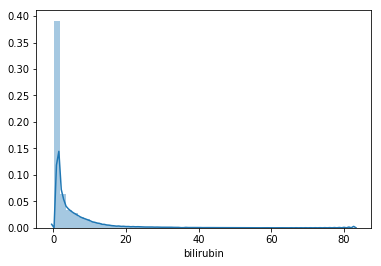

AxesSubplot(0.125,0.125;0.775x0.755)


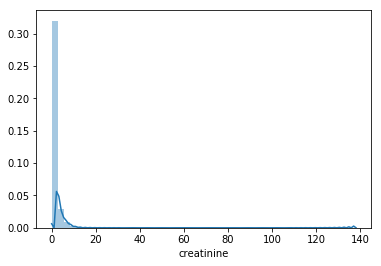

AxesSubplot(0.125,0.125;0.775x0.755)


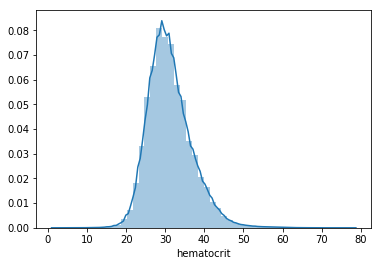

AxesSubplot(0.125,0.125;0.775x0.755)


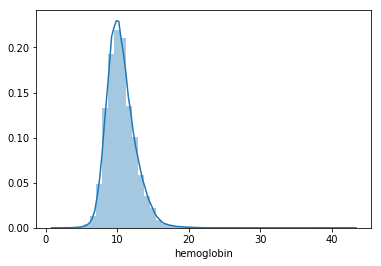

AxesSubplot(0.125,0.125;0.775x0.755)


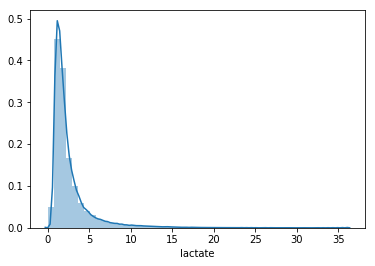

AxesSubplot(0.125,0.125;0.775x0.755)


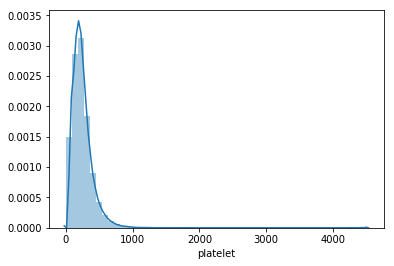

AxesSubplot(0.125,0.125;0.775x0.755)


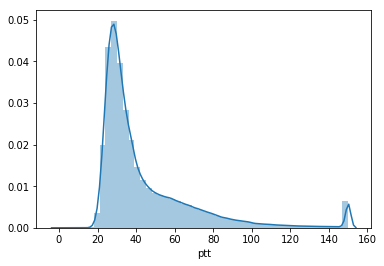

AxesSubplot(0.125,0.125;0.775x0.755)


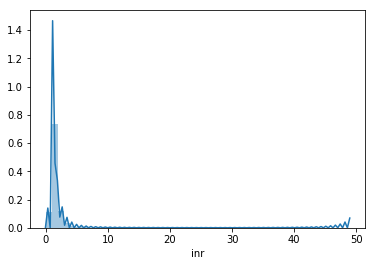

AxesSubplot(0.125,0.125;0.775x0.755)


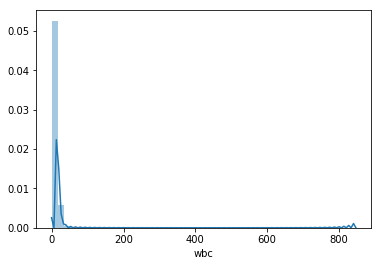

AxesSubplot(0.125,0.125;0.775x0.755)


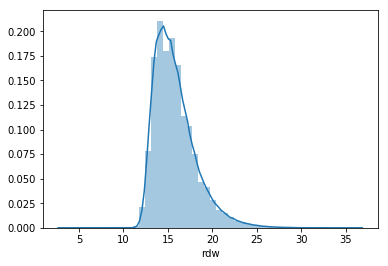

In [137]:
def labDistr(feature):
    feature_data = df_lab[feature].dropna()
    plt.figure()
    plt.show()
    return sns.distplot(feature_data)

for i in df_lab.columns[2:]:
    print(labDistr(i))

## Pulling in prescription data

In [ ]:
%%time
# Creating one dataframe per drug (we can consolidate after feature selection?)

def query_prescrip(drug_desc):
    general_query = """ 
        SELECT p.subject_id, p.hadm_id, p.startdate, p.enddate,
        p.drug, p.drug_name_poe, p.drug_name_generic, a.admittime, a.dischtime
        FROM prescriptions p
        INNER JOIN admissions a
        ON p.hadm_id = a.hadm_id
        WHERE startdate < dischtime
        AND """
    drug_specific = drug_desc
    whole_query = general_query + drug_specific
    return pd.read_sql_query(whole_query, con)

# Vancomycin and neo-synephrine require special queries
df_vanco = query_prescrip("""(lower(drug) LIKE '%vancomycin%' 
OR lower(drug) LIKE '%vancocin%' 
OR lower(drug_name_poe) LIKE '%vancomycin%'
OR lower(drug_name_generic) LIKE '%vancomycin%');""")

df_neosyn = query_prescrip("""(lower(drug) LIKE 'neo%ephrine%'
      OR lower(drug) LIKE 'phenylephrine%');""")

# Other drugs use same query format
def gen_drug_desc(drug):
    gen_drug_query = "(lower(drug) LIKE '%" + drug + "%' OR lower(drug_name_poe) LIKE '%"\
                        + drug + "%' OR lower(drug_name_generic) LIKE '%" + drug + "%');"
    return gen_drug_query

df_neostig = query_prescrip(gen_drug_desc('neostigmine'))
df_glycopyr = query_prescrip(gen_drug_desc('glycopyrrolate'))
df_ceftriax = query_prescrip(gen_drug_desc('ceftriaxone'))
df_atropsulf = query_prescrip(gen_drug_desc('atropine sulfate'))
df_chlorhex = query_prescrip(gen_drug_desc('chlorhexidine'))
df_nitroglyc = query_prescrip(gen_drug_desc('nitroglycerin'))
df_nitropruss = query_prescrip(gen_drug_desc('nitroprusside'))
df_lansopraz = query_prescrip(gen_drug_desc('lansoprazole'))
    

#df_vanco = query_prescrip(vanco_desc)
#query_prescrip(neosyn_desc)


In [139]:
# How many rows in each dataframe?

print('vancomycin:', df_vanco.shape[0], 'rows')
print('neosynephrine:', df_neosyn.shape[0], 'rows')
print('neostigmine:', df_neostig.shape[0], 'rows')
print('glycopyrrolate:', df_glycopyr.shape[0], 'rows')
print('ceftriaxone:', df_ceftriax.shape[0], 'rows')
print('atropine sulfate:', df_atropsulf.shape[0], 'rows')
print('chlorhexidine:', df_chlorhex.shape[0], 'rows')
print('nitroglycerin:', df_nitroglyc.shape[0], 'rows')
print('nitroprusside:', df_nitropruss.shape[0], 'rows')
print('lansoprazole:', df_lansopraz.shape[0], 'rows')

vancomycin: 68734 rows
neosynephrine: 22312 rows
neostigmine: 6812 rows
glycopyrrolate: 8036 rows
ceftriaxone: 8722 rows
atropine sulfate: 5119 rows
chlorhexidine: 12124 rows
nitroglycerin: 21892 rows
nitroprusside: 4896 rows
lansoprazole: 7424 rows


In [ ]:
df_vanco.head()

In [ ]:
# Converting prescription feature to binary

drug_list = ['vancomycin', 'neosynephrine', 'neostigmine', 'glycopyrrolate', 'ceftriaxone', 
'atropine sulfate', 'chlorhexidine', 'nitroglycerin', 'nitroprusside', 'lansoprazole']
df_druglist = [df_vanco, df_neosyn, df_neostig, df_glycopyr, df_ceftriax, df_atropsulf, df_chlorhex,  df_nitroglyc,
              df_nitropruss, df_lansopraz]

# Create new copy of df2 with one column per prescription feature, values True/False 
df2_prescrip = df2.copy()
for i in range(len(drug_list)):
    df2_prescrip[drug_list[i]] = df2_prescrip['hadm_id'].isin(df_druglist[i]['hadm_id'])
df2_prescrip.head()

## Pulling in procedure data

In [ ]:
%%time
# Creating one dataframe per procedure (we can consolidate after feature selection?)

def query_proc(proc_desc):
    general_query = """ 
        SELECT pr.subject_id, pr.hadm_id, d.icd9_code, d.short_title, d.long_title
        FROM procedures_icd pr
        INNER JOIN d_icd_procedures d
        ON pr.icd9_code = d.icd9_code
        WHERE """
    proc_specific = proc_desc
    whole_query = general_query + proc_specific
    return pd.read_sql_query(whole_query, con)

df_parentinf = query_proc("short_title = 'Parent infus nutrit sub';")
df_serumtransf = query_proc("short_title = 'Serum transfusion NEC';")
df_skinsut = query_proc("short_title = 'Skin closure NEC';")
df_vasopress = query_proc("short_title = 'Infusion of vasopressor';")
df_mammCAB = query_proc("short_title = '1 int mam-cor art bypass';")
df_aortoCBT = query_proc("short_title = 'Aortocor bypas-2 cor art' OR short_title = 'Aortocor bypas-3 cor art';")
df_platetransf = query_proc("short_title = 'Platelet transfusion';")
df_intercath = query_proc("short_title = 'Insert intercostal cath';")

In [138]:
# How many rows in each dataframe?

print('parenteral infusion:', df_parentinf.shape[0], 'rows')
print('serum transfusion:', df_serumtransf.shape[0], 'rows')
print('skin suture:', df_skinsut.shape[0], 'rows')
print('infusion of vasopressor:', df_vasopress.shape[0], 'rows')
print('single internal mammary-coronary artery bypass:', df_mammCAB.shape[0], 'rows')
print('aortocoronary bypass T:', df_aortoCBT.shape[0], 'rows')
print('platelet transfusion:', df_platetransf.shape[0], 'rows')
print('insertion of intercostal catheter:', df_intercath.shape[0], 'rows')


parenteral infusion: 4244 rows
serum transfusion: 2028 rows
skin suture: 719 rows
infusion of vasopressor: 832 rows
single internal mammary-coronary artery bypass: 4401 rows
aortocoronary bypass T: 3407 rows
platelet transfusion: 1235 rows
insertion of intercostal catheter: 1717 rows


In [ ]:
df_parentinf.head()

In [ ]:
143045 in df_aortoCBT['hadm_id'].unique()

In [ ]:
# Converting procedure feature to binary

proc_list = ['parent_inf', 'serum_transf', 'skin_sut', 'inf_vasopress',
            'single_int_mammCAB', 'aorto_CBT', 'platelet_transf', 'ins_inter_cath']
df_proclist = [df_parentinf, df_serumtransf, df_skinsut, df_vasopress, df_mammCAB, df_aortoCBT, df_platetransf, df_intercath]

# Create new copy of df2 with one column per procedure feature, values True/False 
df2_proc = df2.copy()
for i in range(len(proc_list)):
    df2_proc[proc_list[i]] = df2_proc['hadm_id'].isin(df_proclist[i]['hadm_id'])
df2_proc.head()

## Pulling in diagnosis category ("department") data

In [ ]:
q_merge = """SELECT d.SUBJECT_ID, d.HADM_ID, d.ICD9_CODE, lookup.SHORT_TITLE, lookup.LONG_TITLE 
                from DIAGNOSES_ICD d
                left join d_icd_diagnoses lookup 
                on d.ICD9_CODE = lookup.ICD9_CODE;"""

df_department = pd.read_sql_query(q_merge, con)

In [140]:
len(df_department)

651047

In [ ]:
df_department.head()

In [141]:
df_department['icd9_code'].value_counts()

4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
25000     9058
2724      8690
51881     7497
5990      6555
53081     6326
2720      5930
V053      5779
V290      5519
2859      5406
2449      4917
486       4839
2851      4552
2762      4528
496       4431
99592     3912
V5861     3806
0389      3725
5070      3680
V3000     3566
5859      3435
311       3431
40390     3421
3051      3358
412       3278
2875      3065
         ...  
72270        1
79510        1
5286         1
27709        1
6984         1
V1020        1
V1643        1
5161         1
72672        1
55001        1
80441        1
V9039        1
66942        1
5291         1
E8589        1
V062         1
E9463        1
1489         1
38908        1
99585        1
4481         1
V045         1
32724        1
74343        1
80410        1
7817         1
38921        1
81252        1
V6110        1
75444        1
Name: icd9_code, Length: 6984, dtype: int64

In [ ]:
# Reading the ICD 9 Codes. First three digit are important. Last two if available are supplementary
df_department['ICD_PC'] = df_department['icd9_code'].astype(str).str[:3]

In [ ]:
df_department.head()

In [ ]:
#converting to numeric
df_department['int_icd9']=pd.to_numeric(df_department.ICD_PC, errors='coerce')

In [ ]:
df_department.head()

In [ ]:
conditions = [
    (df_department['int_icd9'] > 0) & (df_department['int_icd9'] <= 139),
    (df_department['int_icd9'] >= 140) & (df_department['int_icd9'] <= 239),
    (df_department['int_icd9'] >= 240) & (df_department['int_icd9'] <= 279),
    (df_department['int_icd9'] >= 280) & (df_department['int_icd9'] <= 289),
    (df_department['int_icd9'] >= 290) & (df_department['int_icd9'] <= 319),
    (df_department['int_icd9'] >= 320) & (df_department['int_icd9'] <= 389),
    (df_department['int_icd9'] >= 390) & (df_department['int_icd9'] <= 459),
    (df_department['int_icd9'] >= 460) & (df_department['int_icd9'] <= 519),
    (df_department['int_icd9'] >= 520) & (df_department['int_icd9'] <= 579),
    (df_department['int_icd9'] >= 580) & (df_department['int_icd9'] <= 629),
    (df_department['int_icd9'] >= 630) & (df_department['int_icd9'] <= 679),
    (df_department['int_icd9'] >= 680) & (df_department['int_icd9'] <= 709),
    (df_department['int_icd9'] >= 710) & (df_department['int_icd9'] <= 739),
    (df_department['int_icd9'] >= 740) & (df_department['int_icd9'] <= 759),
    (df_department['int_icd9'] >= 760) & (df_department['int_icd9'] <= 779),
    (df_department['int_icd9'] >= 780) & (df_department['int_icd9'] <= 799),
    (df_department['int_icd9'] >= 800) & (df_department['int_icd9'] <= 999),
    (df_department.icd9_code.str.startswith('E', na=False)) | (df_department.icd9_code.str.startswith('V', na=False)),
    
]
choices = ['infectious and parasitic diseases', 'neoplasms',\
           'endocrine, nutritional and metabolic diseases, and immunity disorders',\
           'diseases of the blood and blood-forming organs','mental disorders',\
           'diseases of the nervous system and sense organs','diseases of the circulatory system',\
           'diseases of the respiratory system','diseases of the digestive system',\
           'diseases of the genitourinary system','complications of pregnancy, childbirth, and the puerperium',\
           'diseases of the skin and subcutaneous tissue','diseases of the musculoskeletal system and connective tissue',\
          'congenital anomalies','certain conditions originating in the perinatal period','symptoms, signs, and ill-defined conditions',\
          'injury and poisoning','external causes of injury and supplemental classification']
df_department['Department'] = np.select(conditions, choices, default='null')
#print(df_merge)

In [ ]:
df_department.head(15)

In [ ]:
#df_merge = df_merge.drop(['ICD_PC'],axis=1)

In [143]:
df_department.Department.value_counts()

diseases of the circulatory system                                       140257
external causes of injury and supplemental classification                 97249
endocrine, nutritional and metabolic diseases, and immunity disorders     69592
diseases of the respiratory system                                        44825
injury and poisoning                                                      42948
diseases of the digestive system                                          38527
diseases of the genitourinary system                                      32867
symptoms, signs, and ill-defined conditions                               29691
diseases of the blood and blood-forming organs                            25262
mental disorders                                                          24876
diseases of the nervous system and sense organs                           23334
infectious and parasitic diseases                                         20264
certain conditions originating in the pe

In [ ]:
df_department2 = df_department[df_department['Department']!='null']

In [ ]:
#ICD codes are null
df_department2.head()

In [144]:
df_department_freq = df_department2.groupby('hadm_id')['Department'].nunique()

In [ ]:
df_department_freq = df_department_freq.reset_index();

In [ ]:
df_department_freq = df_department_freq.rename(index=str, columns = {"Department": "No_of_Depart"});

In [ ]:
df_department3 = pd.merge(df_department2,df_department_freq, on = 'hadm_id', how = 'inner')

In [145]:
len(df_department3)

651000

In [146]:
# Four most frequent diagnoses per hospital stay
df_top1_depart = df_department3.groupby(['hadm_id'])['Department'].agg(lambda x:x.value_counts().index[0])

In [ ]:
df_top1_depart = df_top1_depart.reset_index()

In [ ]:
df_top1_depart = df_top1_depart.rename(index=str, columns = {'Department': 'Depart1' } );

In [ ]:
df_department4 = df_department3[['hadm_id','No_of_Depart']].drop_duplicates()
df_top1_merge = pd.merge(df_top1_depart[['hadm_id','Depart1']],df_department4 , on ='hadm_id', how = 'left')

In [ ]:
df_top1_merge.head()

In [147]:
len(df_top1_merge)

58929

In [ ]:
#Some of the patients have only one diagnoses.
df_top2_depart = df_department3.groupby(['hadm_id'])['Department'].value_counts().nsmallest()
df_top2_depart

In [148]:
df_department3.Department.nunique()

18

In [ ]:
df_circ = df_department3[df_department3['Department']=='diseases of the circulatory system']
df_geni = df_department3[df_department3['Department']=='diseases of the genitourinary system']
df_resp = df_department3[df_department3['Department']=='diseases of the respiratory system']

In [ ]:
df_endo = df_department3[df_department3['Department']=='endocrine, nutritional and metabolic diseases, and immunity disorders']
df_musko = df_department3[df_department3['Department']=='diseases of the musculoskeletal system and connective tissue']
df_blood = df_department3[df_department3['Department']=='diseases of the blood and blood-forming organs']
df_diges = df_department3[df_department3['Department']=='diseases of the digestive system']
df_nerv = df_department3[df_department3['Department']=='diseases of the nervous system and sense organs']

In [ ]:
df_neo = df_department3[df_department3['Department']=='neoplasms']
df_sym = df_department3[df_department3['Department']=='symptoms, signs, and ill-defined conditions']
df_ext = df_department3[df_department3['Department']=='external causes of injury and supplemental classification']
df_ment = df_department3[df_department3['Department']=='mental disorders']
df_injury = df_department3[df_department3['Department']=='injury and poisoning']
df_skin = df_department3[df_department3['Department']=='diseases of the skin and subcutaneous tissue']
df_infect = df_department3[df_department3['Department']=='infectious and parasitic diseases']
df_congen = df_department3[df_department3['Department']=='congenital anomalies']


In [ ]:
df_pren = df_department3[df_department3['Department']=='certain conditions originating in the perinatal period']
df_preg = df_department3[df_department3['Department']=='complications of pregnancy, childbirth, and the puerperium']


In [ ]:
depart_list = ['diseases of the circulatory system','diseases of the genitourinary system','diseases of the respiratory system',\
              'endocrine, nutritional and metabolic diseases, and immunity disorders','diseases of the musculoskeletal system and connective tissue',\
              'diseases of the blood and blood-forming organs','diseases of the digestive system','diseases of the nervous system and sense organs',\
              'neoplasms','symptoms, signs, and ill-defined conditions','external causes of injury and supplemental classification',\
              'mental disorders','injury and poisoning','diseases of the skin and subcutaneous tissue','infectious and parasitic diseases',\
              'congenital anomalies']
df_departlist = [df_circ, df_geni, df_resp, df_endo, df_musko, df_blood, df_diges, df_nerv, df_neo, df_sym, df_ext, df_ment, df_injury, df_skin, df_infect, df_congen]


# Create new copy of df2 with one column per procedure feature, values True/False 
df_depart = df2.copy()
for i in range(len(depart_list)):
    
    df_depart[depart_list[i]] = df_depart['hadm_id'].isin(df_departlist[i]['hadm_id'])
    

df_depart.head()

In [149]:
df_depart.columns

Index(['subject_id', 'hadm_id', 'ethnicity', 'insurance', 'gender',
       'admittime', 'dischtime', 'age_on_admiss', 'length_of_stay',
       'readmit_time', 'is_readmit', 'diseases of the circulatory system',
       'diseases of the genitourinary system',
       'diseases of the respiratory system',
       'endocrine, nutritional and metabolic diseases, and immunity disorders',
       'diseases of the musculoskeletal system and connective tissue',
       'diseases of the blood and blood-forming organs',
       'diseases of the digestive system',
       'diseases of the nervous system and sense organs', 'neoplasms',
       'symptoms, signs, and ill-defined conditions',
       'external causes of injury and supplemental classification',
       'mental disorders', 'injury and poisoning',
       'diseases of the skin and subcutaneous tissue',
       'infectious and parasitic diseases', 'congenital anomalies'],
      dtype='object')

In [ ]:
df_depart_final = pd.merge(df_depart,df_top1_merge , on ='hadm_id', how = 'left')

In [ ]:
df_depart_final.head()

In [150]:
df_depart_final.columns

Index(['subject_id', 'hadm_id', 'ethnicity', 'insurance', 'gender',
       'admittime', 'dischtime', 'age_on_admiss', 'length_of_stay',
       'readmit_time', 'is_readmit', 'diseases of the circulatory system',
       'diseases of the genitourinary system',
       'diseases of the respiratory system',
       'endocrine, nutritional and metabolic diseases, and immunity disorders',
       'diseases of the musculoskeletal system and connective tissue',
       'diseases of the blood and blood-forming organs',
       'diseases of the digestive system',
       'diseases of the nervous system and sense organs', 'neoplasms',
       'symptoms, signs, and ill-defined conditions',
       'external causes of injury and supplemental classification',
       'mental disorders', 'injury and poisoning',
       'diseases of the skin and subcutaneous tissue',
       'infectious and parasitic diseases', 'congenital anomalies', 'Depart1',
       'No_of_Depart'],
      dtype='object')

## Merging dataframes

In [ ]:
#Merging Admission, Vitals, Lab and Diagnoses(Department) Dataframes

In [ ]:
merge_df1 = pd.merge(df2_follow, lab_statsdf, on ='hadm_id', how ='inner')

In [151]:
len(merge_df1)

50255

In [ ]:
merge_df2 = pd.merge(merge_df1, vitals_statsdf, on = 'hadm_id', how = 'inner')

In [152]:
len(merge_df2)

48941

In [ ]:
merge_df3 = pd.merge(merge_df2, df_depart_final[['hadm_id','diseases of the circulatory system',
       'diseases of the genitourinary system',
       'diseases of the respiratory system',
       'endocrine, nutritional and metabolic diseases, and immunity disorders',
       'diseases of the musculoskeletal system and connective tissue',
       'diseases of the blood and blood-forming organs',
       'diseases of the digestive system',
       'diseases of the nervous system and sense organs', 'neoplasms',
       'symptoms, signs, and ill-defined conditions',
       'external causes of injury and supplemental classification',
       'mental disorders', 'injury and poisoning',
       'diseases of the skin and subcutaneous tissue',
       'infectious and parasitic diseases', 'congenital anomalies', 'Depart1',
       'No_of_Depart']], on='hadm_id', how = 'left')

In [ ]:
merge_df3.head()

In [153]:
merge_df3.dtypes;

In [154]:
len(merge_df3)

48941

In [ ]:
#Merging prescription and procedures data
merge_df4 = pd.merge(df2_proc,df2_prescrip[['hadm_id','vancomycin', 'neosynephrine',
       'neostigmine', 'glycopyrrolate', 'ceftriaxone', 'atropine sulfate',
       'chlorhexidine', 'nitroglycerin', 'nitroprusside', 'lansoprazole']], on = 'hadm_id', how='inner')

In [ ]:
#Merging df4 and df3 together
merge_df5 = pd.merge(merge_df3,merge_df4[['hadm_id','parent_inf', 'serum_transf', 'skin_sut', 'inf_vasopress',
       'single_int_mammCAB', 'aorto_CBT', 'platelet_transf', 'ins_inter_cath',
       'vancomycin', 'neosynephrine', 'neostigmine', 'glycopyrrolate',
       'ceftriaxone', 'atropine sulfate', 'chlorhexidine', 'nitroglycerin',
       'nitroprusside', 'lansoprazole']], on='hadm_id', how = 'inner')

In [ ]:
merge_df5.head()

In [155]:
print(len(merge_df5.columns))
#print(merge_df5.columns.values)

93


## Selecting the readmissions/nonreadmissions instances

In [156]:
df_readmit = merge_df5[merge_df5['followed_by_readmit'] == True]
num_readmit = len(df_readmit)
print('There were', num_readmit, 'stays which were followed by early readmissions.')

There were 3046 stays which were followed by early readmissions.


(There were 3188 such stays when we selected readmits before merging with all the other feature dataframes.)

In [157]:
df_nonreadmit = merge_df5[merge_df5['followed_by_readmit'] == False]#.reset_index(drop=True)
num_nonreadmit = len(df_nonreadmit)
print('There were', num_nonreadmit, 'stays which were NOT followed by early readmissions.')

There were 45895 stays which were NOT followed by early readmissions.


(There were 47678 such stays when we selected nonreadmits before merging with all the other feature dataframes.)

In [ ]:
# Randomly selection (without replacement) of equal number of stays not followed by readmissions
import random
# Ensuring reproducibility
random.seed(10)

nonreadmit_samp = random.sample(range(num_nonreadmit), num_readmit)
# Showing first 10
nonreadmit_samp[:10]

In [ ]:
df_nonreadmit_samp = df_nonreadmit.iloc[nonreadmit_samp,:]
df_nonreadmit_samp.head()

# Concatenating the readmission and non-readmission-sample dataframes

In [158]:
df_data = pd.concat([df_readmit, df_nonreadmit_samp]).reset_index(drop=True)
print(len(df_data), 'rows')

6092 rows


In [ ]:
df_data.head()

In [159]:
df_data.columns.values

array(['subject_id', 'hadm_id', 'ethnicity', 'insurance', 'gender',
       'admittime', 'dischtime', 'age_on_admiss', 'length_of_stay',
       'readmit_time', 'is_readmit', 'followed_by_readmit',
       'bilirubin_min', 'bilirubin_median', 'bilirubin_max',
       'creatinine_min', 'creatinine_median', 'creatinine_max',
       'hematocrit_min', 'hematocrit_median', 'hematocrit_max',
       'hemoglobin_min', 'hemoglobin_median', 'hemoglobin_max',
       'lactate_min', 'lactate_median', 'lactate_max', 'platelet_min',
       'platelet_median', 'platelet_max', 'ptt_min', 'ptt_median',
       'ptt_max', 'inr_min', 'inr_median', 'inr_max', 'wbc_min',
       'wbc_median', 'wbc_max', 'rdw_min', 'rdw_median', 'rdw_max',
       'heartrate_min', 'heartrate_median', 'heartrate_max', 'sysbp_min',
       'sysbp_median', 'sysbp_max', 'resprate_min', 'resprate_median',
       'resprate_max', 'tempc_min', 'tempc_median', 'tempc_max',
       'spo2_min', 'spo2_median', 'spo2_max',
       'diseases of the 

How many unique patients?

In [160]:
print('Readmits:', df_data[df_data['followed_by_readmit'] == True]['subject_id'].nunique())

Readmits: 2345


In [161]:
print('Non-readmits:', df_data[df_data['followed_by_readmit'] == False]['subject_id'].nunique())

Non-readmits: 3002


### Checking number of True/False values in each class

In [162]:
for i in range(-18, 0):
    print(df_data.groupby('followed_by_readmit')[df_data.columns.values[i]].value_counts())

followed_by_readmit  parent_inf
False                False         2868
                     True           178
True                 False         2808
                     True           238
Name: parent_inf, dtype: int64
followed_by_readmit  serum_transf
False                False           2928
                     True             118
True                 False           2897
                     True             149
Name: serum_transf, dtype: int64
followed_by_readmit  skin_sut
False                False       2997
                     True          49
True                 False       3024
                     True          22
Name: skin_sut, dtype: int64
followed_by_readmit  inf_vasopress
False                False            3003
                     True               43
True                 False            2986
                     True               60
Name: inf_vasopress, dtype: int64
followed_by_readmit  single_int_mammCAB
False                False                 2749
  

### Visualize distribution of vital signs data for readmits vs. nonreadmits

In [163]:
# Selecting only vital signs and followed_by_readmit columns

df_data_vitals = df_data[np.concatenate((vitals_statsdf.columns.values[1:], ['followed_by_readmit']))]

In [ ]:
df_data_vitals.head()

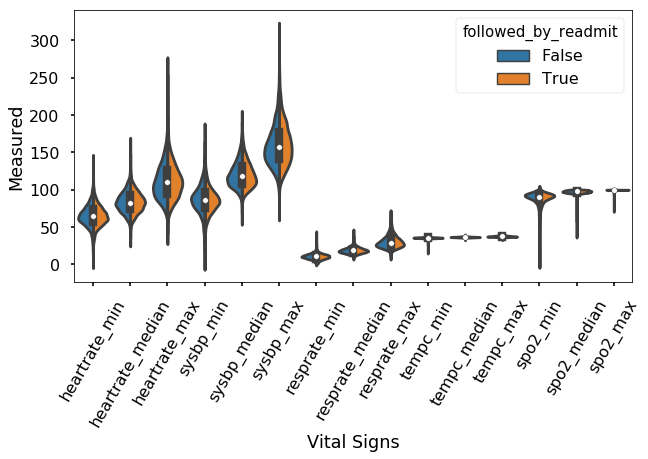

In [165]:
# Creating violinplot for all vital signs

vitals_colnames = df_data_vitals.iloc[:, :-1].columns.values
df_dv_melt = df_data_vitals.melt(id_vars = 'followed_by_readmit', value_vars=vitals_colnames,
                                 var_name='Vital Signs', value_name='Measured')

with sns.plotting_context('poster'):
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='Vital Signs', y='Measured', hue='followed_by_readmit', data=df_dv_melt, split=True)
    plt.xticks(rotation=60)
    plt.savefig('vitals_violin.png', bbox_inches='tight')

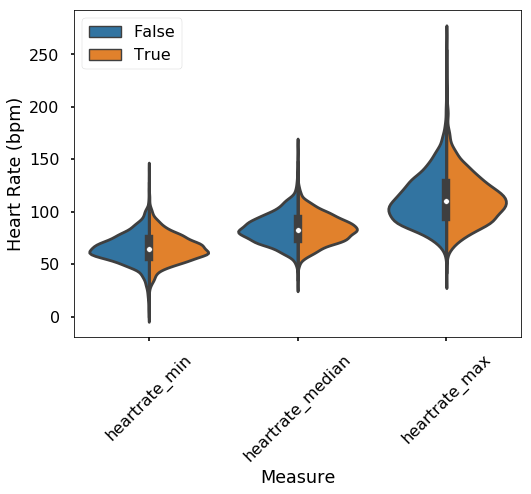

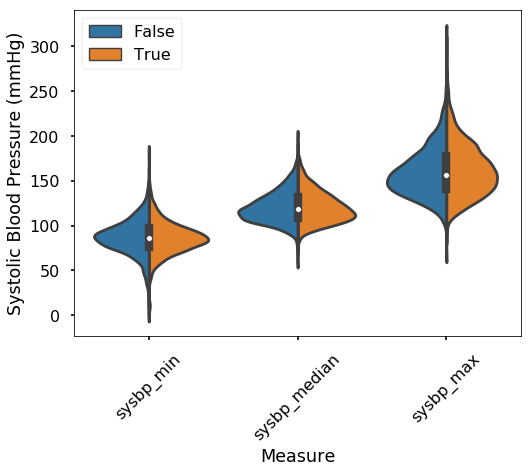

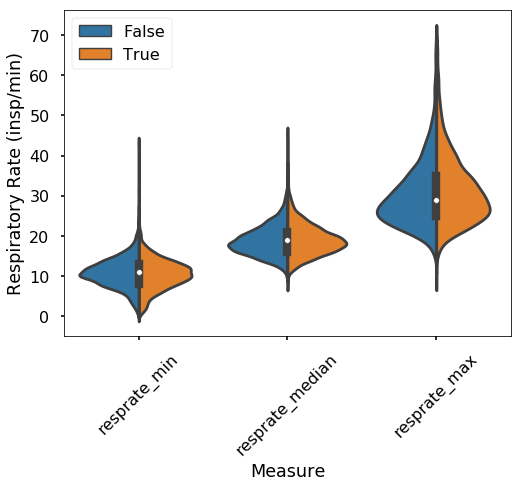

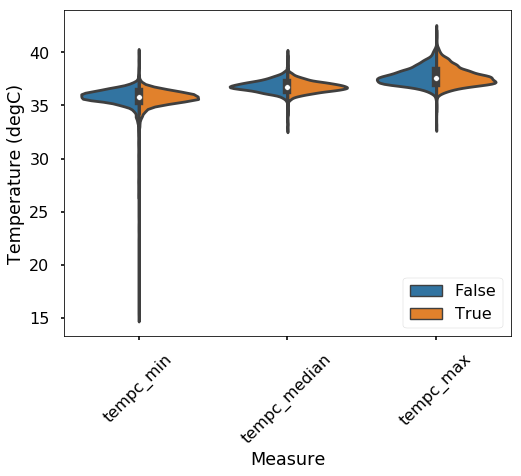

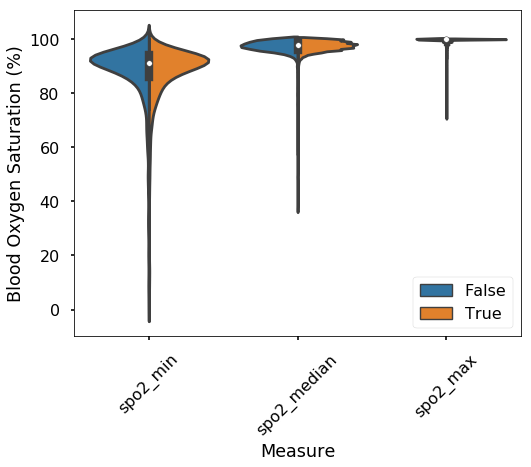

In [166]:
# Creating individual violinplot for each vital sign

vitals_name_unit = ['Heart Rate (bpm)', 'Systolic Blood Pressure (mmHg)', 'Respiratory Rate (insp/min)',
                    'Temperature (degC)', 'Blood Oxygen Saturation (%)']
df_hr_melt = df_data_vitals.melt(id_vars = 'followed_by_readmit', value_vars=vitals_colnames[:3],
                                 var_name='Measure', value_name=vitals_name_unit[0])
df_sbp_melt = df_data_vitals.melt(id_vars = 'followed_by_readmit', value_vars=vitals_colnames[3:6],
                                 var_name='Measure', value_name=vitals_name_unit[1])
df_rr_melt = df_data_vitals.melt(id_vars = 'followed_by_readmit', value_vars=vitals_colnames[6:9],
                                 var_name='Measure', value_name=vitals_name_unit[2])
df_t_melt = df_data_vitals.melt(id_vars = 'followed_by_readmit', value_vars=vitals_colnames[9:12],
                                 var_name='Measure', value_name=vitals_name_unit[3])
df_sat_melt = df_data_vitals.melt(id_vars = 'followed_by_readmit', value_vars=vitals_colnames[12:15],
                                 var_name='Measure', value_name=vitals_name_unit[4])

df_vitals_list = [df_hr_melt, df_sbp_melt, df_rr_melt, df_t_melt, df_sat_melt]
with sns.plotting_context('poster'):
    for i in range(len(df_vitals_list)):
        plt.figure(figsize=(8,6))
        sns.violinplot(x='Measure', y=vitals_name_unit[i], hue='followed_by_readmit', data=df_vitals_list[i], split=True)
        plt.xticks(rotation=45)
        if i < 3:
            plt.legend(loc='upper left')
        else:
            plt.legend(loc='lower right')
        plt.savefig('vitals' + str(i) + '_violin.png', bbox_inches='tight')

### Visualize distribution of lab data for readmits vs. nonreadmits

In [ ]:
# Selecting only lab values and followed_by_readmit columns

df_data_lab = df_data[np.concatenate((lab_statsdf.columns.values[1:], ['followed_by_readmit']))]

In [ ]:
df_data_lab.head()

In [ ]:
# Creating violinplot for all lab data

lab_colnames = df_data_lab.iloc[:, :-1].columns.values
df_lab_melt = df_data_lab.melt(id_vars = 'followed_by_readmit', value_vars=lab_colnames,
                                 var_name='Lab Values', value_name='Measured')

with sns.plotting_context('poster'):
    plt.figure(figsize=(20, 5))
    sns.violinplot(x='Lab Values', y='Measured', hue='followed_by_readmit', data=df_lab_melt, split=True)
    plt.xticks(rotation=60)
    plt.savefig('lab_violin.png', bbox_inches='tight')

In [ ]:
# Creating individual violinplot for each lab value

lab_name_unit = ['Bilirubin (mg/dL)', 'Creatinine (mg/dL)', 'Hematocrit (%)', 'Hemoglobin (g/dL)', 'Lactate (mmol/L)',
                 'Platelet (K/uL)', 'PTT (sec)', 'INR', 'WBC (K/uL)', 'RDW (%)']
'''df_bili_melt = df_data_lab.melt(id_vars = 'followed_by_readmit', value_vars=lab_colnames[:3],
                                 var_name='Measure', value_name=lab_name_unit[0])
df_vitals_list = [df_hr_melt, df_sbp_melt, df_rr_melt, df_t_melt, df_sat_melt]
with sns.plotting_context('poster'):
    for i in range(len(df_vitals_list)):
        plt.figure(figsize=(8,6))
        sns.violinplot(x='Measure', y=vitals_name_unit[i], hue='followed_by_readmit', data=df_vitals_list[i], split=True)
        plt.xticks(rotation=45)
        if i < 3:
            plt.legend(loc='upper left')
        else:
            plt.legend(loc='lower right')
        plt.savefig('vitals' + str(i) + '_violin.png', bbox_inches='tight')'''

In [ ]:
#merge_df = df2.merge(df_vitals, on = "hadm_id", how = "inner")

In [ ]:
#merge_agg_df = merge_df.groupby('hadm_id').agg('mean')


In [ ]:
merge_agg_df.isnull

In [ ]:
#merge_agg_df.isnull().sum()

In [ ]:
#merge_agg_df.shape

In [ ]:
#merge_agg_df.describe()

In [ ]:
#merge_agg_df.isnull().sum()

In [ ]:
#merge_agg_df.describe()

In [ ]:
#(merge_agg_df.isnull().sum()/merge_agg_df.count())* 100

In [ ]:
corr = merge_agg_df.corr()
sns.heatmap(corr)


In [ ]:
merge_agg_df.age_on_admiss.describe()

In [ ]:
q10 = 'select distinct(icd9_code) from procedures_icd'
df10 = pd.read_sql_query(q10, con)

In [ ]:
df10;